# Assignment 3

**Team**:
- Gurpreet Singh (150259)
- Kamlesh Kumar Biloniya (160317)

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, unicode_literals

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from torch.autograd import Variable
from torchvision import transforms, models, datasets

**Comment**: Setting training parameters for the resnet model

In [3]:
input_size = 224

gpu_device = 0

load_trained = True
save_trained = True

one_layer = True
train_full = True

# Choose your hyper-parameters using validation data
batch_size = 50
num_epochs = 100
hyp_momentum = 0.9
learning_rate =  0.001

## Helper Functions

**Comment**: Defining general functions for use over the rest of the code

In [4]:
def intersection_over_union(rec1, rec2):
    """
    This function gives the intersection over union
    value for two boxes given as arguments
    
    Arguments
        - rec1: First box defined as a tuple ->
                ((x, y), (ws_x, ws_y))
                where (x, y) is the coordinate of
                the top left point and (ws_x, ws_y)
                is the window size
        - rec2: Second box defined same as rec1
        
    Output
        Intersection over union value for rec1 and
        rec2
    """
    
    loc1, ws1 = rec1
    loc2, ws2 = rec2
    
    dx = min(loc1[0] + ws1[0], loc2[0] + ws2[0]) - max(loc1[0], loc2[0])
    dy = min(loc1[1] + ws1[1], loc2[1] + ws2[1]) - max(loc1[1], loc2[1])
    
    a1 = ws1[0] * ws1[1]
    a2 = ws2[0] * ws2[1]
    
    ai = max(dx, 0) * max(dy, 0) # Area of intersection
    
    return ai / (a1 + a2 - ai)

In [5]:
def AP(arr):
    """
    This function gives the average precision
    
    Arguments
        - arr:  An array of ones and zeros giving
                correct/incorrect
        
    Output
        Average precision for the given sequence of
        hits or misses
    """
    
    if len(arr) == 0:
        return None # To distinguish from zero AP
    
    sum_precs = 0
    count = 0
    for i, el in enumerate(arr):
        if el:
            # Recall Point
            
            count += 1
            sum_precs += count / (i + 1)

    if count == 0:
        return 0
            
    return sum_precs / count

In [6]:
def get_hit_miss(img_name, box, class_):
    """
    For a given image, this function checks for every
    correct box if there is significant overlap with
    the passed box (iou > 0.5) to be classified as a
    hit or a miss
    
    Arguments
        - img_name: This argument is used to load the
                annotations
        - box:  Box defined as a tuple ->
                ((x, y), (ws_x, ws_y))
                where (x, y) is the coordinate of
                the top left point and (ws_x, ws_y)
                is the window size
        - class_: Predicted class of the box passed
                in the arguments
        
    Output
        1/0 for hit/miss
    """
    
    import xml.etree.ElementTree as ET
    
    root_dir = "data/test/"
    
    ann_path = os.path.join(root_dir, "Annotations", img_name + ".xml")

    img = cv2.imread(img_path)

    tree = ET.parse(ann_path)
    root = tree.getroot()

    boxes = []

    for child in root:
        if child.tag == 'object' and child[0].tag == 'name':
            c = child[0].text

            if c == class_:
                try:
                    coords = [int(child[4][i].text) for i in range(4)]
                    xmin, ymin, xmax, ymax = coords

                    boxes.append(((xmin - 1, ymin - 1), (xmax - xmin + 1, ymax - ymin + 1)))
                except:
                    continue
                    
    ious = [intersection_over_union(box, box_) for box_ in boxes]

    return int(len(ious) != 0 and max(ious) >= 0.5)

## Building the data

**Comment**: Downloading and extracting the data

In [7]:
%%bash

if [[ ! -d data/train ]]; then
    mkdir data

    wget -O data/train.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    wget -O data/test.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

    tar -xf data/train.tar -C data
    mv data/VOCdevkit/VOC2007 data/train
    rm -r data/VOCdevkit

    tar -xf data/test.tar -C data
    mv data/VOCdevkit/VOC2007 data/test
    rm -r data/VOCdevkit
fi

In [8]:
classes = ['aeroplane', 'background', 'bottle', 'chair']

num_classes = len(classes)

In [9]:
def build_dataset(root_dir, test=False):
    """
    This function crops the images for each bounding
    box if the argument test = False, otherwise simply
    copies the images for which there is a bounding
    box of any class among the three given classes
    
    Arguments
        - root_dir: Location of the data
        - test: Boolean to specify whether the data is
                test/train data
    """
    if test:
        path = os.path.join(root_dir, "processed", "all")
        if not os.path.exists(path):
            os.makedirs(path)
    else:    
        for c in classes:
            path = os.path.join(root_dir, "processed", c)
            if not os.path.exists(path):
                os.makedirs(path)

    images = glob(os.path.join(root_dir, "JPEGImages", "*.jpg"))

    import xml.etree.ElementTree as ET

    background_patches = 0

    counts = { c: 1 for c in classes }
    for img_path in images:
        img_name = img_path.split('/')[-1].split('.')[0]

        ann_path = os.path.join(root_dir, "Annotations", img_name + ".xml")

        img = cv2.imread(img_path)

        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []

        for child in root:
            if child.tag == 'object' and child[0].tag == 'name':
                c = child[0].text

                if test and c in classes:
                    cv2.imwrite(os.path.join(root_dir, "processed/all", img_name + ".jpg"), img)
                    
                else:
                    try:
                        coords = [int(child[4][i].text) for i in range(4)]
                        xmin, ymin, xmax, ymax = coords

                        boxes.append(((xmin - 1, ymin - 1), (xmax - xmin + 1, ymax - ymin + 1)))
                    except:
                        continue

                    if c in classes:
                        cropped_img = img[ymin-1:ymax, xmin-1:xmax]
                        save_path = os.path.join(root_dir, "processed", c, str(counts[c]) + ".jpg")

                        cv2.imwrite(save_path, cropped_img)

                        counts[c] += 1

        if background_patches < 2500 and len(boxes) > 0:
            try:
                # Find random boxes for background images which
                # have low overlap with any of the three classes
                # and not all 20 as we found this to give better
                # results
                
                xmin = np.random.randint(0, img.shape[1] - 50)
                ymin = np.random.randint(0, img.shape[0] - 50)

                xmax = np.random.randint(xmin + 50, img.shape[1])
                ymax = np.random.randint(ymin + 50, img.shape[0])
                
                # 50 is added so that the window size is at least 50

                bpatch = ((xmin, ymin), (xmax - xmin + 1, ymax - ymin + 1))
                ious = [intersection_over_union(bpatch, box) for box in boxes]

                if max(ious) < 0.1:
                    cropped_img = img[ymin:ymax+1, xmin:xmax+1]
                    save_path = os.path.join(
                        root_dir, "processed/background", str(background_patches + 1) + ".jpg"
                    )

                    cv2.imwrite(save_path, cropped_img)

                    background_patches += 1
            except:
                pass

In [10]:
if False: # Change to True to build the datasets
    build_dataset("./data/train")
    build_dataset("./data/test", test=True)

## Loading the Data

**Comment**: Load the dataset using dataloaders. This is easier than creating a separate class as suggested in the template

In [11]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join("data", x, "processed"), None if x == "test" else data_transforms[x]
    ) for x in ["train", "test"]
}

def my_collate(batch):
    assert(len(batch) == 1)
    
    img, label = batch[0]
    
    return img, label

dataloaders_dict = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"], batch_size=batch_size,
        shuffle=True, num_workers=4
    ),
    "test": torch.utils.data.DataLoader(
        image_datasets["test"], batch_size=1,
        shuffle=False, num_workers=4, collate_fn=lambda x: x[0][0],
    )
}

## Training the Network

In [12]:
device = torch.device(
    "cuda:%d" % (gpu_device)
    if torch.cuda.is_available() else "cpu"
)

In [13]:
class ResNet2(models.ResNet):
    """
    This is a modified class for the resnet model
    to allow concatenation of the output from an
    intermediate layer for the two-layer variant
    """
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        
        y = self.maxpool2(x)
        
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        
        x = torch.cat([x, y], dim=1)
        
        x = self.fc(x)

        return x

In [14]:
one_layer = True
train_full = False
        
if one_layer:
    resnet18 = models.resnet18(pretrained=True)
    
else:
    resnet18 = ResNet2(models.resnet.BasicBlock, [2, 2, 2, 2])
    resnet18.maxpool2 = nn.MaxPool2d(kernel_size=20, stride=10, padding=1)
    resnet18.load_state_dict(models.resnet.model_zoo.load_url(models.resnet.model_urls['resnet18']))
    
    resnet18.fc.in_features *= 2

if not train_full:
    for param in resnet18.parameters():
        param.requires_grad = False
    
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    
resnet18 = resnet18.to(device)

print("Parameters to Update:")

params_to_update = []
params_to_update_ = resnet18.named_parameters()

# This avoids back prop through the whole network
# if train_full is False

if not train_full:
    for name, param in params_to_update_:
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)

else:
    for name, param in params_to_update_:
        if param.requires_grad == True:
            print("\t", name)
        params_to_update.append(param)

Parameters to Update:
	 fc.weight
	 fc.bias


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, learning_rate, hyp_momentum)

In [16]:
def train(model, data):
    """
    This is the standard training function
    
    Arguments:
        - model: This is the resnet model to be
                trained
        - data: This is the dataloader for the
                training data
    """
    
    model.train()
    
    epoch_len = len(data.dataset)
    
    with tqdm(range(num_epochs)) as bar:
        for _ in bar:
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in data:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(
                    torch.argmax(outputs, 1) == labels.data
                )
                
            bar.set_postfix({
                "loss": "%.4f" % (running_loss / epoch_len),
                "acc": "%.4f" % (running_corrects.double() / epoch_len)
            })

**Comment**: Load trained model if possible and save the model after training

In [17]:
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

saved_model_path = "one_layer.pt" if one_layer else "two_layer.pt"
saved_model_path = os.path.join("saved_models", saved_model_path)

if load_trained:
    try:
        resnet18.load_state_dict(torch.load(saved_model_path))
    except:
        train(resnet18, dataloaders_dict["train"])
else:
    train(resnet18, dataloaders_dict["train"])

if save_trained:
    torch.save(resnet18.state_dict(), saved_model_path)

In [18]:
resnet18.eval() # Set eval mode as there is no more training involved
None

## Testing and Accuracy Calculation

In [19]:
def sliding_window(img, step, ws):
    """
    This function yields sliding windows over an
    image
    
    Arguments:
        - img:  The image as a PIL image or a 2D
                array
        - step: The stride/step to move for the
                next window
        - ws:   The window size as tuple ->
                (ws_x, ws_y)
    """
    
    img = np.array(img)
    
    arr = []
    for y in range(0, img.shape[0] - ws[1], step):
        for x in range(0, img.shape[1] - ws[0], step):
            arr.append(((x, y), img[y:y + ws[1], x:x + ws[0]]))
            
            if len(arr) == 10:
                locs, imgs = zip(*arr)
                yield imgs, locs
                
                arr = []
                
    if len(arr) != 0:
        locs, imgs = zip(*arr)
        yield imgs, locs

In [20]:
def get_bounding_boxes(img):
    """
    This function returns all bounding boxes with
    their predicted classes and probabilities
    
    Arguments:
        - img:  The image as a PIL image
    """
    
    # These are the window sizes considered for detection
    wss = [(100, 100), (100, 250), (250, 100), (200, 200), (400, 400)]
    
    for ws in wss:
        for patches, locs in sliding_window(img, int(min(ws) / 3), ws):
            patches = [Image.fromarray(patch) for patch in patches]
            
            # Transform each patch to give as inputs to the resnet model
            patches = [data_transforms["test"](patch).numpy() for patch in patches]
            
            patches = torch.from_numpy(np.array(patches))
            
            patches = patches.to(device)
            
            probs = resnet18(patches)
            probs = nn.functional.softmax(probs, dim=1)
            probs = probs.detach().cpu().numpy()
            outs = np.argmax(probs, 1)
            
            for i, out in enumerate(outs):
                if out != 1 and probs[i, 1] < 0.3:
                    if (out == 3 and probs[i, out] > 0.97) or (out != 3 and probs[i, out] > 0.8):
                        yield out, locs[i], ws, probs[i]

In [21]:
def non_max_suppression(boxes, c, threshold=0.1):
    """
    This function returns all bounding boxes after
    applying non-maximum suppression based on the logic
    described here:
    https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    
    Arguments:
        - img:  The prediced boxes for an image corresponding
                to the same class
    """
    
    boxes_ = boxes
    
    scores = [x[-1] for x in boxes]
    boxes = [x[:-1] for x in boxes]
    
    areas = [x[1][0] * x[1][1] for x in boxes]
    
    scores_indices = np.argsort(scores).tolist()
    
    boxes_keep_indices = []
    while len(scores_indices) != 0:
        index = scores_indices.pop()
        boxes_keep_indices.append(index)
        
        if not len(scores_indices):
            break
            
        ious = np.array([
            intersection_over_union(boxes[index], boxes[ind])
            for ind in scores_indices
        ])
        
        filtered_indices = set((ious > threshold).nonzero()[0])
        
        scores_indices = [
            v for (i, v) in enumerate(scores_indices)
            if i not in filtered_indices
        ]
        
    return [boxes_[i] for i in boxes_keep_indices]

**Comment**: Generate all predictions and save the predictions along with their image in the folder data/predictions/

In [22]:
if False:
    image_paths = glob("data/test/processed/all/*.jpg")

    # These are the box colours for each class
    outlines = {
        "aeroplane": "black",
        "bottle": "blue",
        "chair": "green"
    }

    if one_layer:
        save_path = "data/predictions/one_layer"
    else:
        save_path = "data/predictions/two_layer"

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    with tqdm(image_paths) as bar:
        for img_path in bar:
            img = Image.open(img_path)
            img_name = img_path.split('/')[-1].split('.')[0]

            draw = ImageDraw.Draw(img)

            boxes = { c:[] for c in classes if c != "background" }

            with open(os.path.join(save_path, img_name + ".txt"), "w") as f:
                for c, loc, ws, probs in get_bounding_boxes(img):
                    c = classes[c]

                    boxes[c].append((loc, ws, probs[classes.index(c)]))
                    print(c, loc[0], loc[1], ws[0], ws[1], " ".join([str(p) for p in probs]), file=f)        

            with open(os.path.join(save_path, img_name + ".txt"), "w") as f:
                for c in boxes:
                    boxes_ = boxes[c] = non_max_suppression(boxes[c], c)
                    for loc, ws, prob in boxes_:
                        print(c, loc[0], loc[1], ws[0], ws[1], " ".join([str(p) for p in probs]), file=f)

                        draw.rectangle([(loc[0], loc[1]), (loc[0] + ws[0], loc[1] + ws[1])], outline=outlines[c], width=2)

            img.save(os.path.join(save_path, img_name + ".jpg"))

## Results

**Note**: The colours of the bounding boxes define the predicted class. The mapping is
    
    - Black  ->  Aeroplane
    - Blue   ->  Bottle
    - Green  ->  Chair

### Single Layer

In [23]:
image_paths = glob("data/predictions/one_layer/*.jpg")

save_path = "data/predictions/one_layer"
    
if not os.path.exists(save_path):
    os.makedirs(save_path)

aps = { c: [] for c in classes if c != "background" }
    
with tqdm(image_paths) as bar:
    for img_path in bar:
        img = Image.open(img_path)
        img_name = img_path.split('/')[-1].split('.')[0]

        draw = ImageDraw.Draw(img)

        def conv(arr, ctype):
            return [ctype(x) for x in arr]
        
        with open(os.path.join(save_path, img_name + ".txt"), "r") as f:
            boxes_ = f.readlines()
            boxes_ = [line.strip().split() for line in boxes_ if line.strip() != ""]
            
            boxes_ = [
                (el[0], conv(el[1:3], int), 
                 conv(el[3:5], int), float(el[5 + classes.index(el[0])]))
                for el in boxes_
            ]
            
            boxes = sorted(boxes_, key=lambda box: box[3], reverse=True)
            
        hits = { c: [] for c in classes if c != "background" }
        for c, loc, ws, score in boxes_:
            hits[c].append(get_hit_miss(img_name, (loc, ws), c))
        
        for c in classes:
            if c != "background":
                ap = AP(hits[c])
                if ap is not None:
                    aps[c].append((img_name, ap))

100%|██████████| 946/946 [00:08<00:00, 110.57it/s]


#### mAP Scores

In [24]:
print("mAP Scores")
for c in classes:
    if c != "background":
        aps[c] = sorted(aps[c], key=lambda x: x[1])
        aps_ = [x[1] for x in aps[c]]
        
        print("\t%s: %f" % (c, sum(aps_) / len(aps_)))

mAP Scores
	aeroplane: 0.049769
	bottle: 0.057549
	chair: 0.219666


#### Correct Plots

/home/fat-fighter/software/conda/envs/machine-learning/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


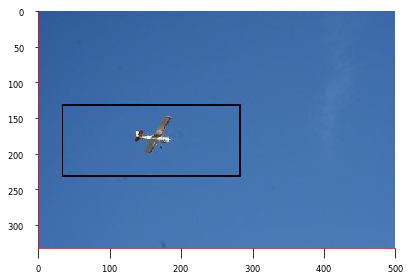

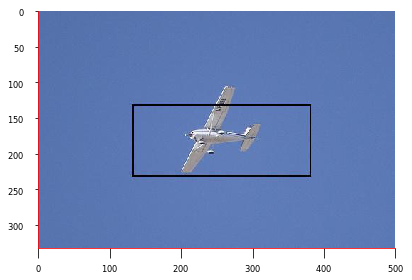

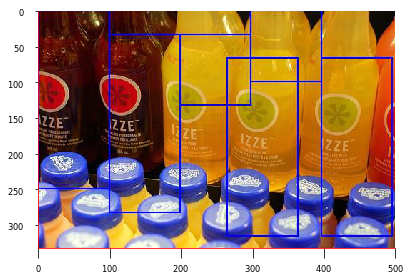

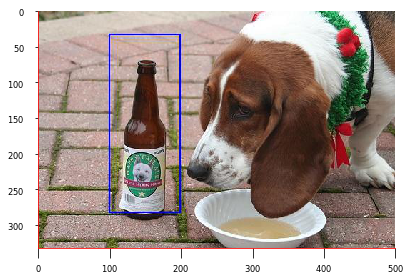

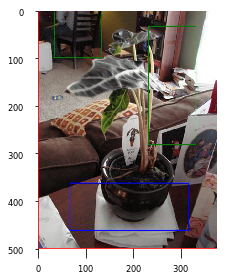

In [25]:
image_names = ["002014", "002908", "001925", "000611", "007319"]

for img_name in image_names:
    img = Image.open(os.path.join(save_path, img_name + ".jpg"))
    
    plt.imshow(img)
    plt.show()

#### Incorrect Plots

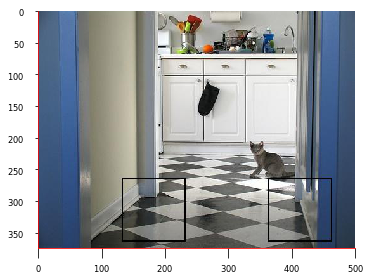

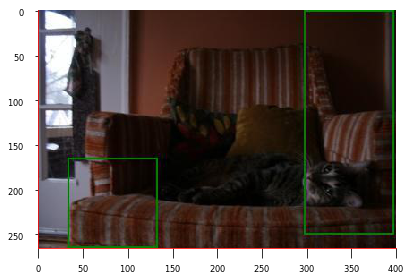

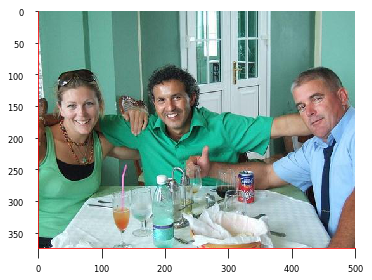

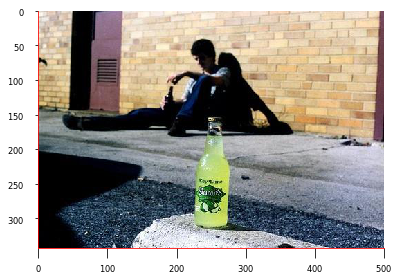

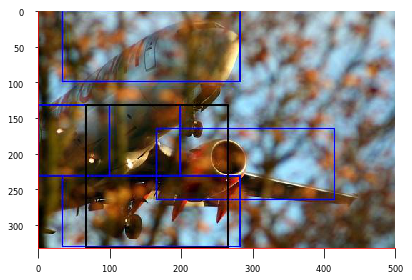

In [26]:
image_names = ["000136", "000157", "000369", "000447", "000600"]

for img_name in image_names:
    img = Image.open(os.path.join(save_path, img_name + ".jpg"))
    
    plt.imshow(img)
    plt.show()

### Two Layer

In [27]:
image_paths = glob("data/predictions/two_layer/*.jpg")

save_path = "data/predictions/two_layer"
    
if not os.path.exists(save_path):
    os.makedirs(save_path)

aps = { c: [] for c in classes if c != "background" }
    
with tqdm(image_paths) as bar:
    for img_path in bar:
        img = Image.open(img_path)
        img_name = img_path.split('/')[-1].split('.')[0]

        draw = ImageDraw.Draw(img)

        def conv(arr, ctype):
            return [ctype(x) for x in arr]
        
        with open(os.path.join(save_path, img_name + ".txt"), "r") as f:
            boxes_ = f.readlines()
            boxes_ = [line.strip().split() for line in boxes_ if line.strip() != ""]
            
            boxes_ = [
                (el[0], conv(el[1:3], int), 
                 conv(el[3:5], int), float(el[5 + classes.index(el[0])]))
                for el in boxes_
            ]
            
            boxes = sorted(boxes_, key=lambda box: box[3], reverse=True)
            
        hits = { c: [] for c in classes if c != "background" }
        for c, loc, ws, score in boxes_:
            hits[c].append(get_hit_miss(img_name, (loc, ws), c))
        
        for c in classes:
            if c != "background":
                ap = AP(hits[c])
                if ap is not None:
                    aps[c].append((img_name, ap))

100%|██████████| 946/946 [00:07<00:00, 130.84it/s]


#### mAP Scores

In [28]:
print("mAP Scores")
for c in classes:
    if c != "background":
        aps[c] = sorted(aps[c], key=lambda x: x[1])
        aps_ = [x[1] for x in aps[c]]
        
        print("\t%s: %f" % (c, sum(aps_) / len(aps_)))

mAP Scores
	aeroplane: 0.056391
	bottle: 0.050636
	chair: 0.223850


#### Correct Plots

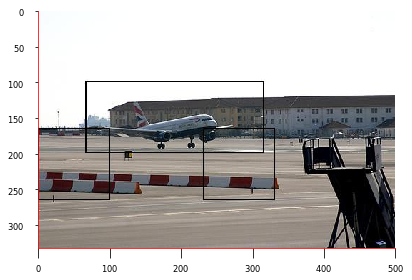

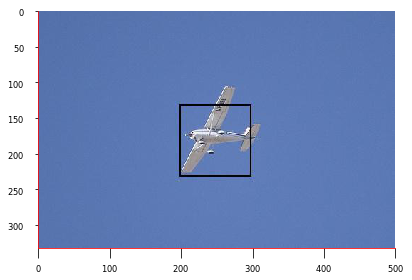

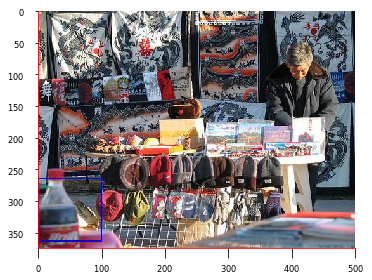

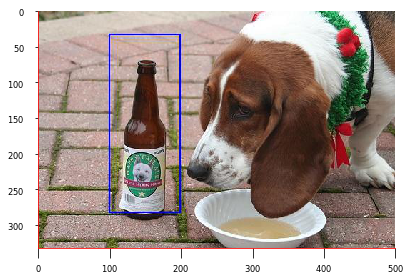

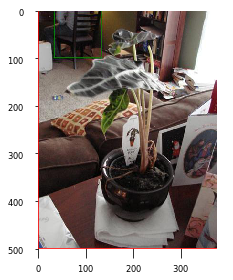

In [29]:
image_names = ["007262", "002908", "002711", "000611", "007319"]

for img_name in image_names:
    img = Image.open(os.path.join(save_path, img_name + ".jpg"))
    
    plt.imshow(img)
    plt.show()

#### Incorrect Plots

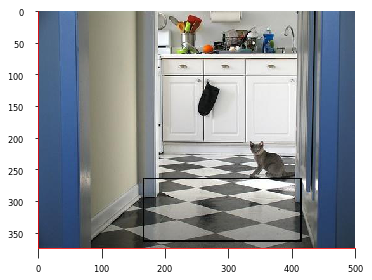

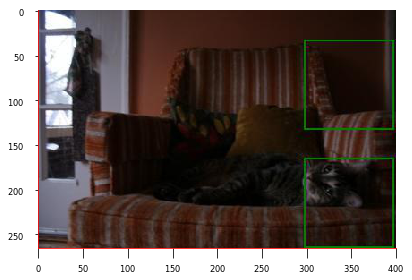

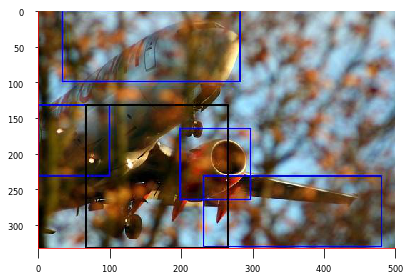

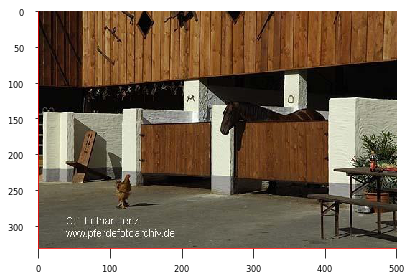

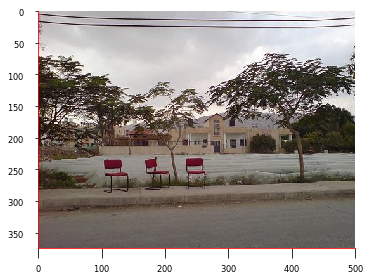

In [30]:
image_names = ["000136", "000157", "000600", "000737", "002100"]

for img_name in image_names:
    img = Image.open(os.path.join(save_path, img_name + ".jpg"))
    
    plt.imshow(img)
    plt.show()